In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
import os
from collections import Counter
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
filepath = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))

In [3]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of students: " + str(len(student_vectors)))
split = int(0.8*len(student_vectors))
print("Number of training sequences: "+str(split)+ ", testing sequences: "+str(len(student_vectors)-split))
print("Number of unique task IDs: " + str(len(task_ids)))
print("List of Task IDs:")
pprint.pprint(task_ids)

Number of students: 11659
Number of training sequences: 9327, testing sequences: 2332
Number of unique task IDs: 10
List of Task IDs:
['1zsCldT4p8.set1',
 'kvig7fcCVc.partb',
 'p7cfRPp-kQ.partb',
 'dTZlXODVzW.partb',
 '1zsCldT4p8.set2',
 'UlJYoQjOUR.partb',
 '9wRCzK1G7F.partb',
 '2yCqg9SbT0.set1',
 'DebcfZEEmI.proper_fractions',
 'nl-M69Ez9k.parta']


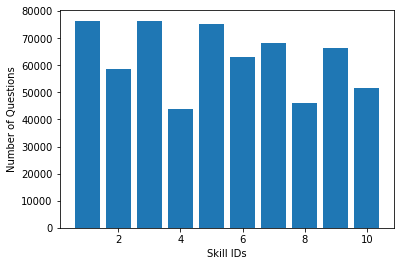

Task IDs mapping: 
Task ID -> 1zsCldT4p8.set1(1) is attempted 76458 times. Max seq len: 240
Task ID -> kvig7fcCVc.partb(2) is attempted 58768 times. Max seq len: 61
Task ID -> p7cfRPp-kQ.partb(3) is attempted 76279 times. Max seq len: 147
Task ID -> dTZlXODVzW.partb(4) is attempted 43769 times. Max seq len: 137
Task ID -> 1zsCldT4p8.set2(5) is attempted 75166 times. Max seq len: 210
Task ID -> UlJYoQjOUR.partb(6) is attempted 63034 times. Max seq len: 193
Task ID -> 9wRCzK1G7F.partb(7) is attempted 68238 times. Max seq len: 180
Task ID -> 2yCqg9SbT0.set1(8) is attempted 46153 times. Max seq len: 119
Task ID -> DebcfZEEmI.proper_fractions(9) is attempted 66271 times. Max seq len: 132
Task ID -> nl-M69Ez9k.parta(10) is attempted 51483 times. Max seq len: 145
625619


In [4]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
totality = 0
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            totality += 1
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
        
umm = np.zeros([10])
umm2 = np.zeros([10])
for i in cnt2:
    umm2[int(i)-1] = cnt2[i]
    umm[int(i)-1] = str(i)
fig, ax = plt.subplots()
ind = np.arange(10) 
ax.bar(ind+1,umm2)
#plt.title("Skill frequency distribution")
ax.set_xlabel("Skill IDs")
ax.set_ylabel("Number of Questions")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))
print(totality)

In [5]:
import math
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def calculate_auc (y_true,y_pred,sequence_lengths=[],plot=False):
    """
    calculate 1 AUC for 1 task ID!
    y_true: the input at time t+1 [number of students, ]
    y_pred: prediction vector at time t
    sequence_lengths: sequence lengths list of all the students
    
    con_y_true, con_y_pred: takes students out of the picture and makes one list with all true and all prediction vectors!
    """
    if sequence_lengths == []: #if no sequence length specified, behave as a normal roc_auc score function
        return roc_auc_score(y_true, y_pred)
    else:
        con_y_true = np.zeros([sum(sequence_lengths)])
        con_y_pred = np.zeros([sum(sequence_lengths)])
        index = 0
        for i in range(len(y_true)): #per student
            for j in range(sequence_lengths[i]): #up to the sequence length
                con_y_true[index] = y_true[i][j]
                if(plot):
                    con_y_pred[index] = y_pred[0][i][j]
                else:
                    con_y_pred[index] = y_pred[i][j]
                index += 1
        fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
        #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
        print("total sequence lengths: "+str(sum(sequence_lengths)))
        if(plot):
            return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
        else:
            return roc_auc_score(con_y_true, con_y_pred)

def o_calculate_auc(true_all_tasks, predictions_all_tasks, sequence_lengths_all_tasks,plot=False):
    """
    calculate concatenated AUC
    true_all_tasks: the concatenated input at time t+1 [number of students, ]
    predictions_all_tasks: prediction vector at time t
    sequence_lengths_all_tasks: sequence lengths list of all the students
    
    con_y_true, con_y_pred: takes students out of the picture and makes one list with all true and all prediction vectors!
    """
    total = 0
    for i in sequence_lengths_all_tasks:
        total += sum(sequence_lengths_all_tasks[i])
    index = 0
    con_y_true = np.zeros([total])
    con_y_pred = np.zeros([total])
    for i in sequence_lengths_all_tasks: #per task ID
        for j in range(len(true_all_tasks[i])): #per student
            for k in range(sequence_lengths_all_tasks[i][j]): #up to sequence length
                con_y_true[index] = true_all_tasks[i][j][k]
                con_y_pred[index] = predictions_all_tasks[i][0][j][k]
                index += 1
    fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
    print(total)
    #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
    if(plot == True):
        return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
    else:
        return roc_auc_score(con_y_true, con_y_pred)

In [6]:
def loadmodel(session, saver, checkpoint_dir):
    session.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(session, os.path.join(checkpoint_dir, ckpt_name))
        print("Model restored successfully")
        return int(ckpt_name[6:])
    else:
        print("No pre-trained model exists, starting from the beginning!")
        return 0

def save(session, saver, checkpoint_dir, step):
    dir1 = os.path.join(checkpoint_dir, "model")
    saver.save(session, dir1, global_step=step)

In [7]:
#recorders over task IDs
test_AUC_all_tasks = {} #making AUC plot over epochs over all task IDs
train_AUC_all_tasks = {} #making AUC plot over epochs over all task IDs
true_all_tasks = {}
true_all_tasks['train'] = {}
true_all_tasks['test'] = {}
predictions_all_tasks = {}
predictions_all_tasks['train'] = {}
predictions_all_tasks['test'] = {}
seqlen_all_tasks = {}
seqlen_all_tasks['train'] = {}
seqlen_all_tasks['test'] = {}
np.set_printoptions(threshold=np.nan)

for i in another_2:
    
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    
    #recorders over epochs
    train_AUC_taski = [] #making AUC plot over epochs
    test_AUC_taski = [] # making AUC plot over epochs
    
    #configuration variables
    len_vector = 1 #length of input encoding, number of input units and number of output units
    padding_experiment = 1000. #to check if masking is working correctly or not
    num_units = 10 #number of recurrent units
    l_rate = 0.01 #initial learning rate
    epochs = 1000 #when in fixed number of epochs
    display_ep = 20 #status report after 'display_ep' epochs, and convergence criterion
    repeat = 1 #number of times to repeat experiments, recorders work according to 1 right now
    
    #make sequences
    index_sp = 0
    index_sp1 = 0
    index_store = 0
    print("index_store = "+str(index_store))
    sequences = []
    sequences_lengths = []
    sequences_lengths1 = [] #for passing to mask
    for p in student_vectors:
        interactions = []
        interactions.append([padding_experiment]) #for getting the first prediction!
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                else:
                    interactions.append([0.])
        index_sp += 1
        if(len(interactions) > 1): #for students who never did that skill at all! we ignore such students!
            index_sp1 += 1
            if(index_sp < split): #things go in training
                sequences_lengths.append(len(interactions)-1)
                sequences_lengths1.append([len(interactions)-1]) 
                sequences.append(interactions)
            else: #things go in testing
                if(index_store == 0):
                    index_store = index_sp1
                sequences_lengths.append(len(interactions)-1)
                sequences_lengths1.append([len(interactions)-1]) 
                sequences.append(interactions)
    if(index_store == 0):
        print("SAD")
    #add padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
    padded_sequences = padded_sequences + padding_experiment
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
    
    #split = int(0.82*len(sequences)) #train/test split
    #split the train and test set
    split1 = index_store
    print("There were "+str(len(sequences))+" students. Total train = "+str(index_store)+", test = "+str(index_sp1-index_store))
    train_x = padded_sequences[:split1,:-1]
    train_y = padded_sequences[:split1,1:]
    train_seqlen = sequences_lengths[:split1]
    test_x = padded_sequences[split1:,:-1]
    test_y = padded_sequences[split1:,1:]
    test_seqlen = sequences_lengths[split1:]
    
    for r in range(repeat): #don't have to repeat results since we fixed the random state
        print("\n\n"+ str(r+1) +" out of "+ str(repeat) + " Time Run.")
        
        # reset graph, fix random seed
        tf.reset_default_graph()
        tf.set_random_seed(1234) #fixing the random states for repeating results
        
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths), len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths), len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])
        condition = tf.placeholder(tf.int32, shape=[], name="condition")
        converged = tf.Variable(0)

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            return outputs
        
        #making predictions and masking cost to feed optimizer
        pred = dynamicRNN(x)

        cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y)
        mask = tf.cond(condition < 1, lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[:split1], maxlen = max(sequences_lengths)), tf.float32), lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[split1:], maxlen = max(sequences_lengths)), tf.float32))
        cost1 = tf.multiply(cost1,tf.transpose(mask, perm=[0, 2, 1]))
        cost1 = tf.reduce_sum(cost1, 1)
        cost1 /= tf.cond(condition < 1, lambda: tf.cast(sequences_lengths1[:split1],tf.float32), lambda: tf.cast(sequences_lengths1[split1:],tf.float32) )
        cost = tf.reduce_mean(cost1)
        optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        saver = tf.train.Saver(max_to_keep=5)
        
        saver_url = "saved_models/2_separate_models_large/"+str(i)+"_model.ckpt"
        
        #execute until cost converges
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            stop = False
            epoch = loadmodel(sess, saver,saver_url)
            print("converged = "+str(converged.eval()))
            if(sess.run(converged) == 1):
                print("model already converged!")
                stop = True
                loss_train,pred_train = sess.run([cost,pred], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
                trainOPTS = calculate_auc(train_y,pred_train,train_seqlen)

                loss_test,pred_test = sess.run([cost,pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
                testOPTS = calculate_auc(test_y,pred_test,test_seqlen)
                #print(np.c_[train_y[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]],pred_train[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]]])
                print("Epoch: " + str(epoch) +", train cost: "+str(loss_train)+", test cost: "+str(loss_test)+ ", train set AUC: " + str(trainOPTS) + ", test set AUC: "+ str(testOPTS) +";")
                train_AUC_taski.append(trainOPTS)
                test_AUC_taski.append(testOPTS)
            cost_prev = 1.0
            while(stop == False):
                epoch += 1
                loss,_ = sess.run([cost,optimizer], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
                
                #status report
                if epoch % display_ep == 0 or epoch == 1:
                    
                    loss_train,pred_train = sess.run([cost,pred], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
                    trainOPTS = calculate_auc(train_y,pred_train,train_seqlen)
                    
                    loss_test,pred_test = sess.run([cost,pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
                    testOPTS = calculate_auc(test_y,pred_test,test_seqlen)
                    #print(np.c_[train_y[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]],pred_train[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]]])
                    print("Epoch: " + str(epoch) +", train cost: "+str(loss_train)+", test cost: "+str(loss_test)+ ", train set AUC: " + str(trainOPTS) + ", test set AUC: "+ str(testOPTS) +";")
                    train_AUC_taski.append(trainOPTS)
                    test_AUC_taski.append(testOPTS)
                    
                    #checking for convergence
                    cost_current = loss_train
                    if abs(cost_prev - cost_current) <= 0.00005:
                        stop = True
                        sess.run(converged.assign(1))
                        print("Model has converged!" + str(converged.eval()))
                    else:
                        cost_prev = cost_current
                    
                    #save model
                    save(sess,saver,saver_url,epoch)

            pred_train = sess.run([pred], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
            predictions_all_tasks['train'][i] = pred_train
            true_all_tasks['train'][i] = train_y
            seqlen_all_tasks['train'][i] = train_seqlen
            pred_test = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
            true_all_tasks['test'][i] = test_y
            predictions_all_tasks['test'][i] = pred_test
            seqlen_all_tasks['test'][i] = test_seqlen
    
    test_AUC_all_tasks[i] = test_AUC_taski
    train_AUC_all_tasks[i] = train_AUC_taski




Calculating for Task ID: 1zsCldT4p8.set1 which has the frequency: 76458

index_store = 0
There were 10244 students. Total train = 9327, test = 917


1 out of 1 Time Run.
No pre-trained model exists, starting from the beginning!
converged = 0
total sequence lengths: 70861
total sequence lengths: 5597
Epoch: 1, train cost: 0.5299397, test cost: 0.5372641, train set AUC: 0.5052850910333776, test set AUC: 0.4874804196520498;
total sequence lengths: 70861
total sequence lengths: 5597
Epoch: 20, train cost: 0.46599102, test cost: 0.47867322, train set AUC: 0.5709264305240784, test set AUC: 0.57356269415871;
total sequence lengths: 70861
total sequence lengths: 5597
Epoch: 40, train cost: 0.45860225, test cost: 0.4718276, train set AUC: 0.5926570477443903, test set AUC: 0.5942544001885057;
total sequence lengths: 70861
total sequence lengths: 5597
Epoch: 60, train cost: 0.4580164, test cost: 0.47130504, train set AUC: 0.5932235807206521, test set AUC: 0.5944928664576746;
total sequence len

total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 20, train cost: 0.40820426, test cost: 0.408527, train set AUC: 0.5107176358208492, test set AUC: 0.48922479739684666;
total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 40, train cost: 0.39632234, test cost: 0.39625895, train set AUC: 0.5399107787014326, test set AUC: 0.5144429253877911;
total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 60, train cost: 0.39537054, test cost: 0.39527717, train set AUC: 0.5401018211412241, test set AUC: 0.5146867913608757;
total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 80, train cost: 0.39502883, test cost: 0.39493158, train set AUC: 0.5401781026999259, test set AUC: 0.514752295986741;
total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 100, train cost: 0.39484248, test cost: 0.39473626, train set AUC: 0.540323333756408, test set AUC: 0.5148693087527157;
total sequence lengths: 61565
total sequence lengths: 13601
Epoch: 

total sequence lengths: 53566
total sequence lengths: 12705
Epoch: 60, train cost: 0.4780194, test cost: 0.47062814, train set AUC: 0.5930860152977457, test set AUC: 0.5891594958539664;
total sequence lengths: 53566
total sequence lengths: 12705
Epoch: 80, train cost: 0.47788757, test cost: 0.47048494, train set AUC: 0.5920786400314063, test set AUC: 0.5880021903573338;
total sequence lengths: 53566
total sequence lengths: 12705
Epoch: 100, train cost: 0.47781718, test cost: 0.47040677, train set AUC: 0.5882317885397201, test set AUC: 0.5839545409891538;
total sequence lengths: 53566
total sequence lengths: 12705
Epoch: 120, train cost: 0.47776902, test cost: 0.47035217, train set AUC: 0.5882480956152518, test set AUC: 0.5839447717043672;
Model has converged!1



Calculating for Task ID: nl-M69Ez9k.parta which has the frequency: 51483

index_store = 0
There were 6369 students. Total train = 5056, test = 1313


1 out of 1 Time Run.
No pre-trained model exists, starting from the beginnin

In [8]:
print("Calculating concatenated AUC")
o_train = o_calculate_auc(true_all_tasks['train'],predictions_all_tasks['train'],seqlen_all_tasks['train'],plot=False)
o_test = o_calculate_auc(true_all_tasks['test'],predictions_all_tasks['test'],seqlen_all_tasks['test'],plot=False)
print("Overall AUC train: "+str(o_train) + ", test: "+str(o_test))

Calculating concatenated AUC
530136
95483
Overall AUC train: 0.5884495388674558, test: 0.5730923972419337


1zsCldT4p8.set1
total sequence lengths: 5597
kvig7fcCVc.partb
total sequence lengths: 3297
p7cfRPp-kQ.partb
total sequence lengths: 14707
dTZlXODVzW.partb
total sequence lengths: 4238
1zsCldT4p8.set2
total sequence lengths: 13601
UlJYoQjOUR.partb
total sequence lengths: 11510
9wRCzK1G7F.partb
total sequence lengths: 13967
2yCqg9SbT0.set1
total sequence lengths: 6100
DebcfZEEmI.proper_fractions
total sequence lengths: 12705
nl-M69Ez9k.parta
total sequence lengths: 9761
95483


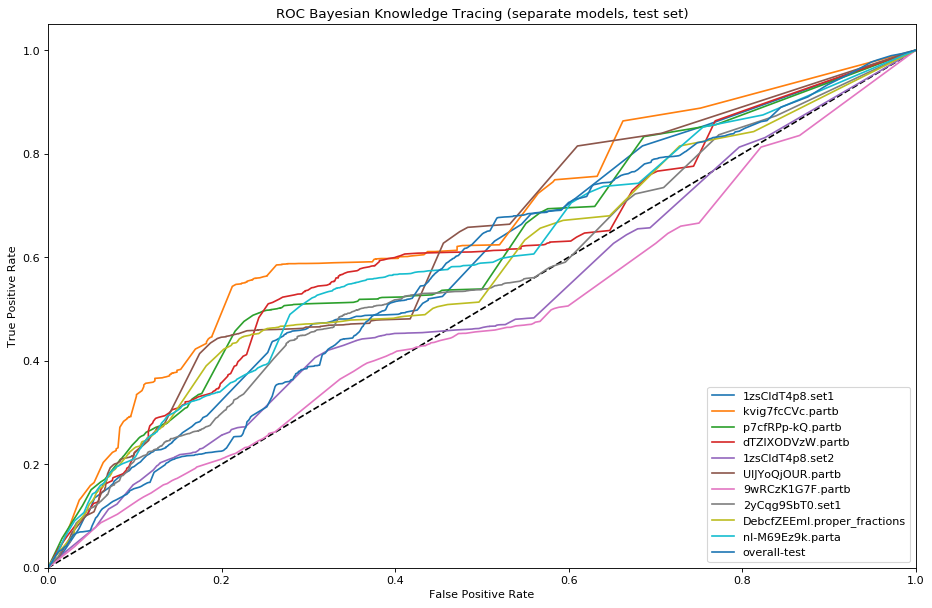

In [12]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (separate models, test set)')

for task_id in another_2:
    print(task_id)
    roc = calculate_auc(true_all_tasks['test'][task_id] , predictions_all_tasks['test'][task_id] , seqlen_all_tasks['test'][task_id],plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['test'],predictions_all_tasks['test'],seqlen_all_tasks['test'],plot=True)
plt.plot(roc[1], roc[2], label='overall-test')
save_obj(roc,'dkt_sep_roc_overall')
plt.legend(loc="lower right")

1zsCldT4p8.set1
total sequence lengths: 70861
kvig7fcCVc.partb
total sequence lengths: 55471
p7cfRPp-kQ.partb
total sequence lengths: 61572
dTZlXODVzW.partb
total sequence lengths: 39531
1zsCldT4p8.set2
total sequence lengths: 61565
UlJYoQjOUR.partb
total sequence lengths: 51524
9wRCzK1G7F.partb
total sequence lengths: 54271
2yCqg9SbT0.set1
total sequence lengths: 40053
DebcfZEEmI.proper_fractions
total sequence lengths: 53566
nl-M69Ez9k.parta
total sequence lengths: 41722
530136


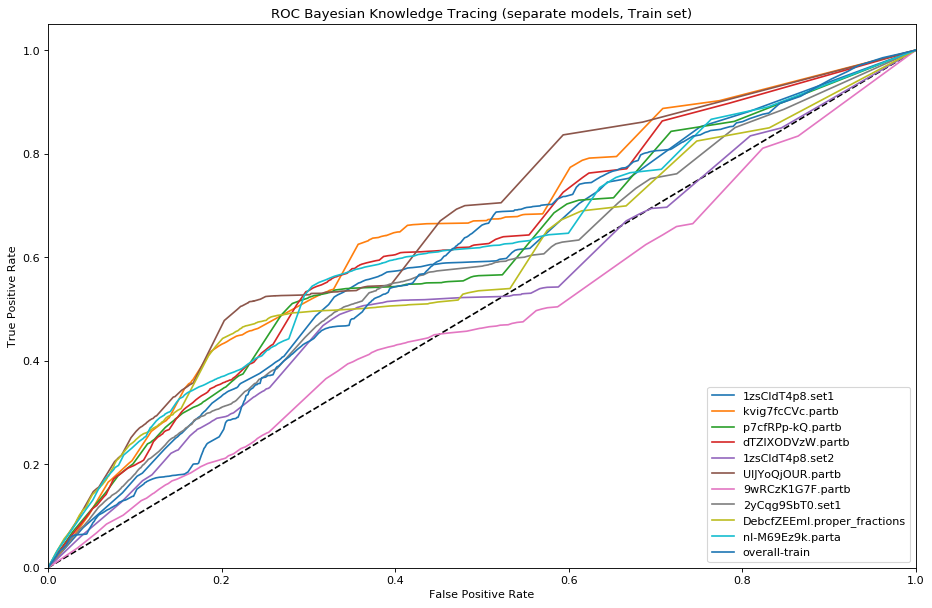

In [13]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (separate models, Train set)')

for task_id in another_2:
    print(task_id)
    roc = calculate_auc(true_all_tasks['train'][task_id],predictions_all_tasks['train'][task_id], seqlen_all_tasks['train'][task_id], plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['train'],predictions_all_tasks['train'],seqlen_all_tasks['train'],plot=True)
plt.plot(roc[1], roc[2], label='overall-train')

plt.legend(loc="lower right")

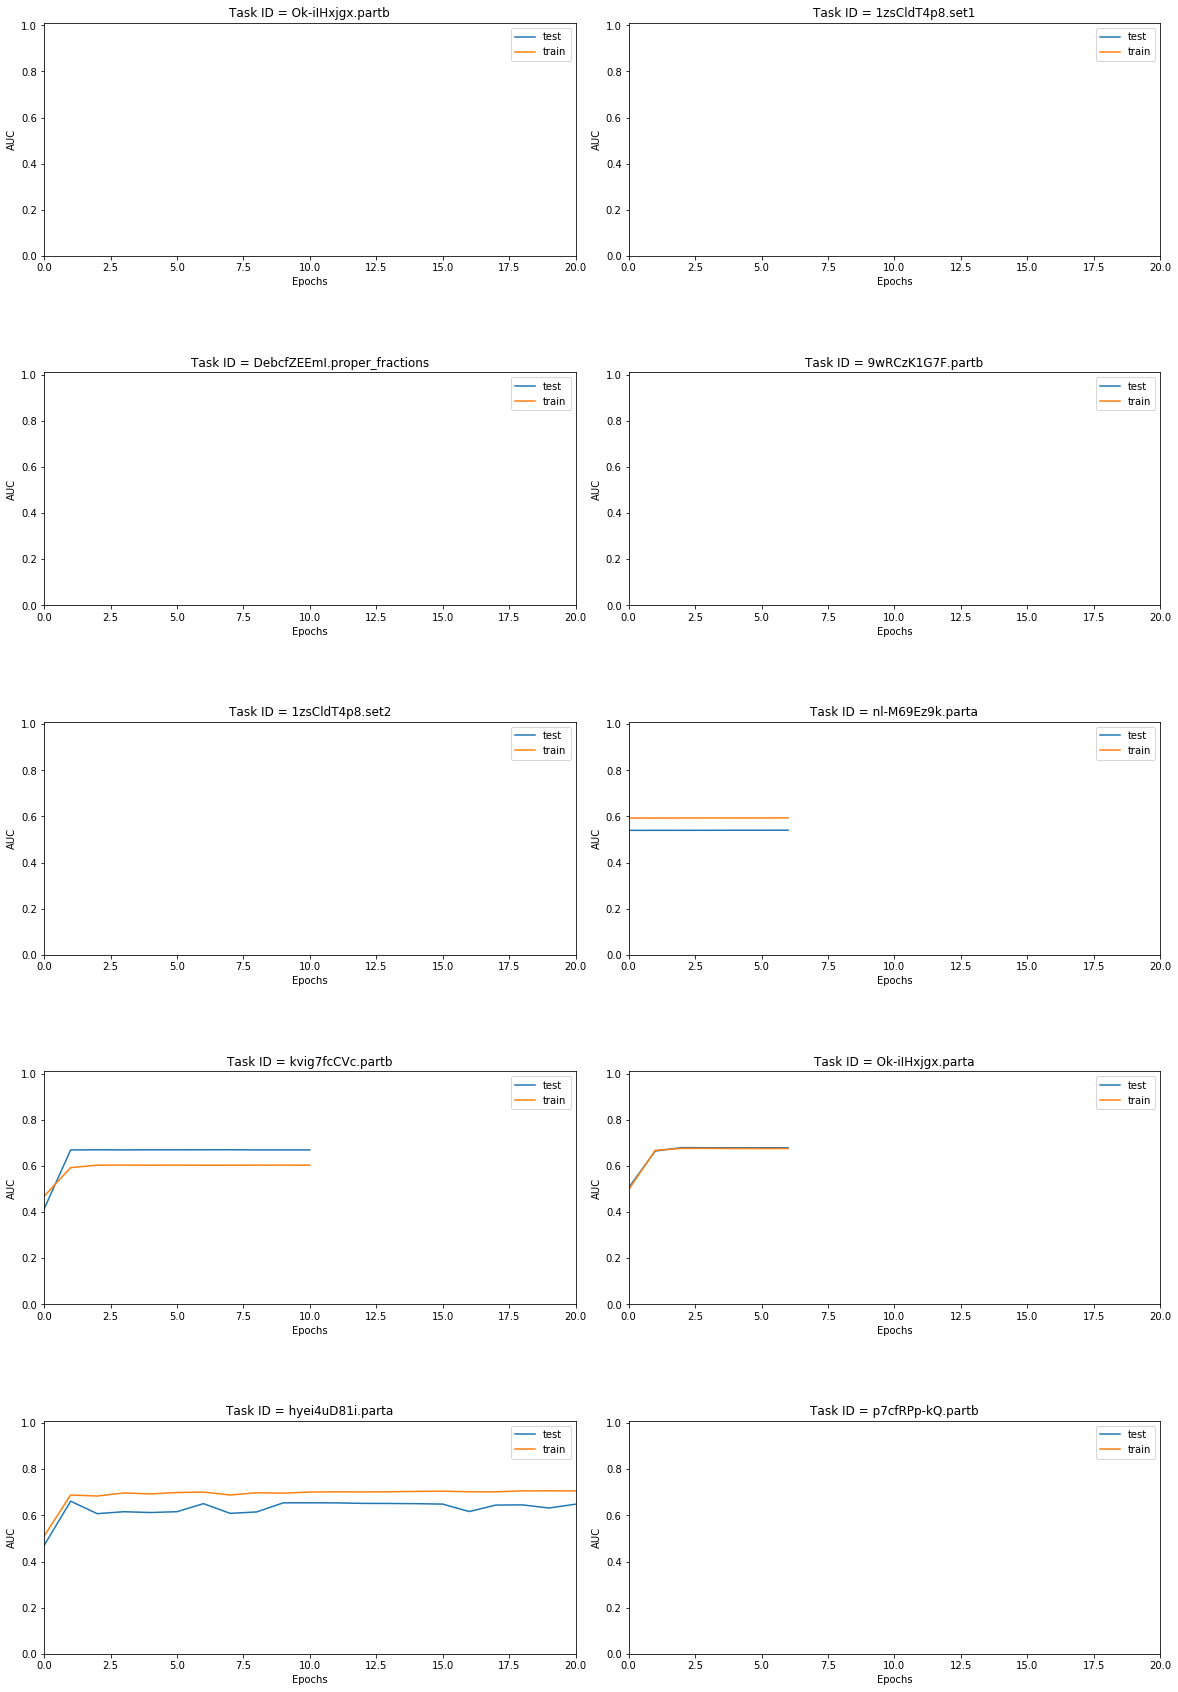

In [74]:
fig, axs = plt.subplots(5,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    axs[i-1].plot(test_AUC_all_tasks[value],label='test')
    axs[i-1].plot(train_AUC_all_tasks[value],label='train')
    axs[i-1].set_ylim(0,1.01)
    axs[i-1].set_xlim(0,20)
    axs[i-1].set_xlabel("Epochs")
    axs[i-1].set_ylabel("AUC")
    axs[i-1].legend(loc="best")
    axs[i-1].set_title("Task ID = "+str(value))

In [14]:
for i in another_2:
    print(i + " final train auc: " + str(round(train_AUC_all_tasks[i][-1],3)) + "; final test auc: "+str(round(test_AUC_all_tasks[i][-1],3)))

1zsCldT4p8.set1 final train auc: 0.593; final test auc: 0.595
kvig7fcCVc.partb final train auc: 0.647; final test auc: 0.662
p7cfRPp-kQ.partb final train auc: 0.6; final test auc: 0.61
dTZlXODVzW.partb final train auc: 0.624; final test auc: 0.607
1zsCldT4p8.set2 final train auc: 0.54; final test auc: 0.515
UlJYoQjOUR.partb final train auc: 0.659; final test auc: 0.625
9wRCzK1G7F.partb final train auc: 0.485; final test auc: 0.48
2yCqg9SbT0.set1 final train auc: 0.575; final test auc: 0.564
DebcfZEEmI.proper_fractions final train auc: 0.588; final test auc: 0.584
nl-M69Ez9k.parta final train auc: 0.612; final test auc: 0.601


Visualizing Data

70861
5597
55467
3301
61572
14707
39523
4246
61565
13601
51524
11510
54271
13967
40045
6108
53566
12705
41722
9761


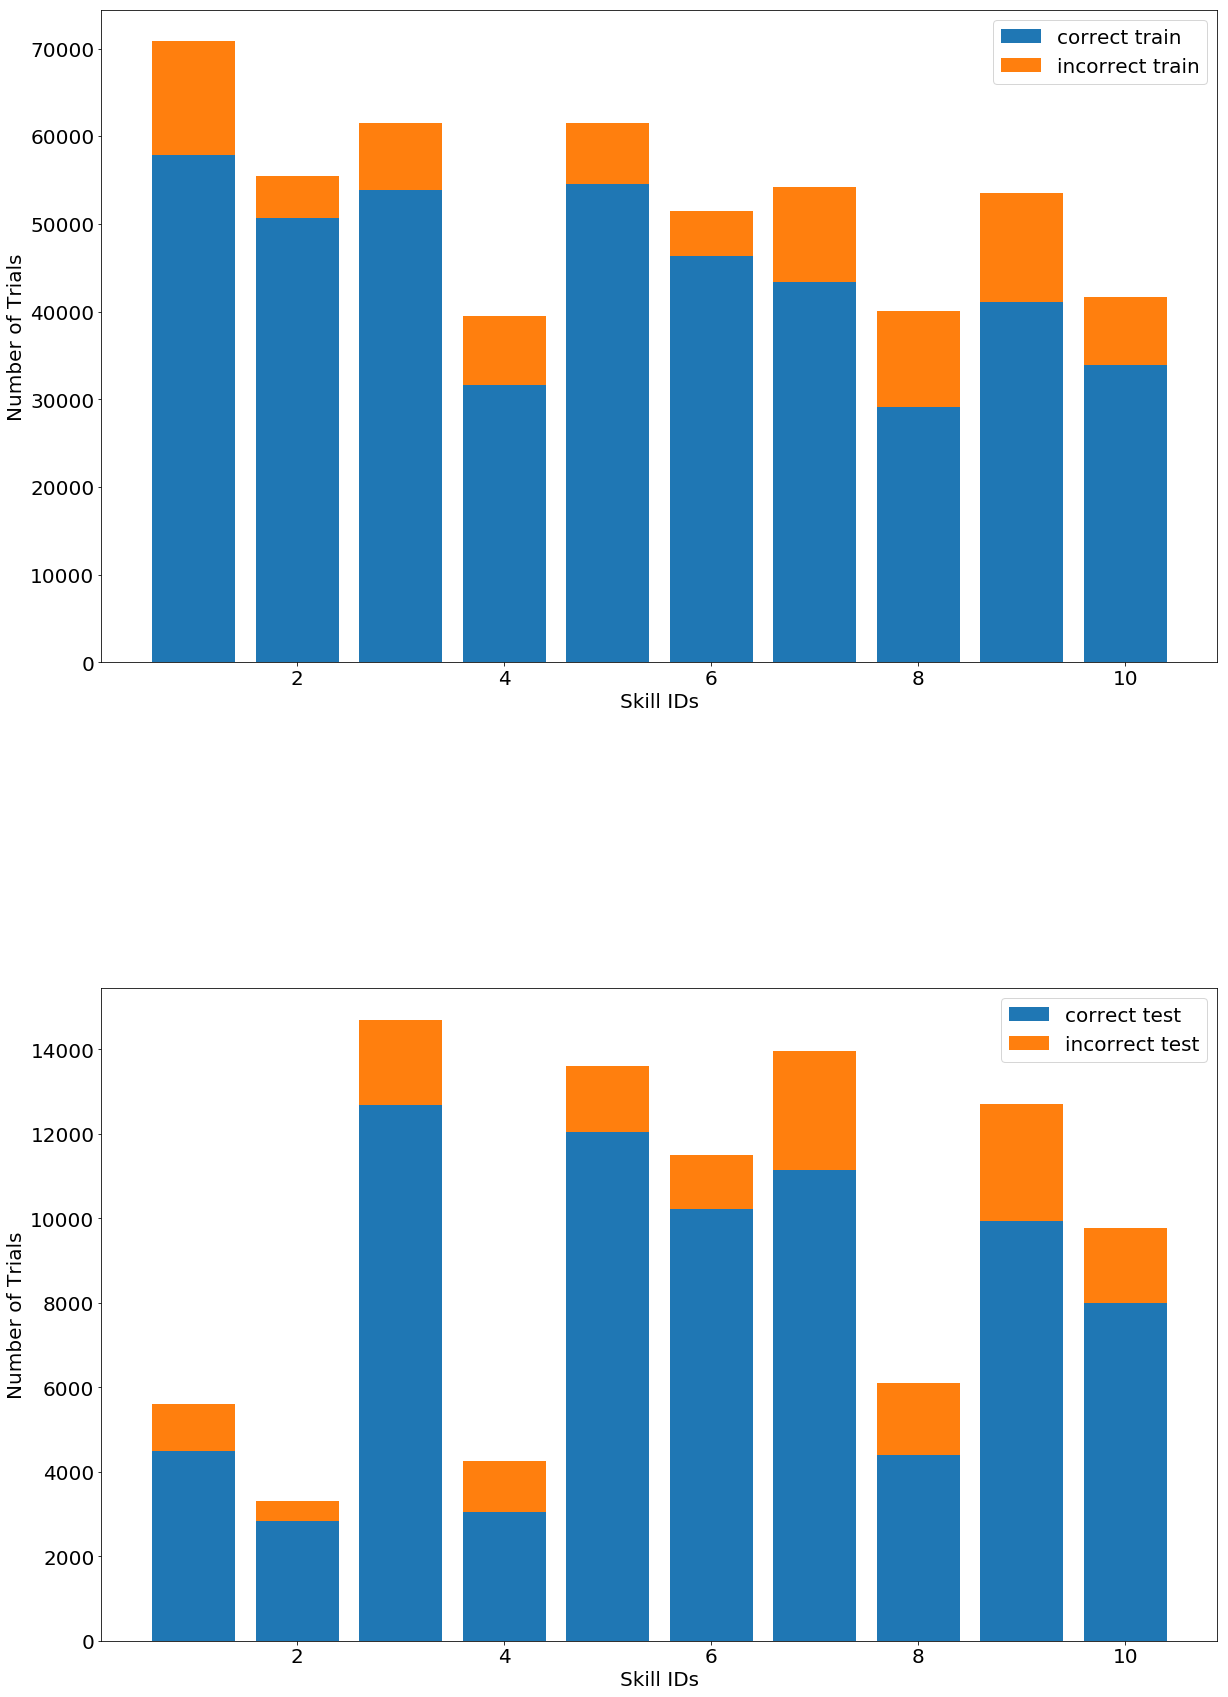

In [47]:
right_ = {}
right_['train'] = np.zeros([10])
right_['test'] = np.zeros([10])
wrong_ = {}
wrong_['train'] = np.zeros([10])
wrong_['test'] = np.zeros([10])
for k in another_2:
    index_tr = 0
    index_te = 0
    right_tr = 0
    right_te = 0
    for idx,i in enumerate(student_vectors):
        if(idx<split): #training set
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    index_tr += 1
                    if(j['correct'] == True):
                        right_tr += 1
        else:
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    index_te += 1
                    if(j['correct'] == True):
                        right_te += 1
    right_['train'][int(another_2[k])-1] = right_tr
    wrong_['train'][int(another_2[k])-1] = index_tr - right_tr
    right_['test'][int(another_2[k])-1] = right_te
    wrong_['test'][int(another_2[k])-1] = index_te - right_te
    print(index_tr)
    print(index_te)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2,1, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i in range(1):
    N = 10
    ind = np.arange(N)+1
    for k in ['train','test']:
        if(k=='train'):
            axs[2*i].bar(ind,right_[k],label="correct "+str(k))
            axs[2*i].bar(ind,wrong_[k],bottom = right_[k],label="incorrect "+str(k))
            #axs[i].set_ylim(0,1.31)
            axs[2*i].legend(loc="best") 
            axs[2*i].set_xlabel("Skill IDs")
            axs[2*i].set_ylabel("Number of Trials")
        else:
            axs[2*i+1].bar(ind,right_[k],label="correct "+str(k))
            axs[2*i+1].bar(ind,wrong_[k],bottom = right_[k],label="incorrect "+str(k))
            #axs[i].set_ylim(0,1.31)
            axs[2*i+1].legend(loc="best") 
            axs[2*i+1].set_xlabel("Skill IDs")
            axs[2*i+1].set_ylabel("Number of Trials")
plt.savefig('right_wrong_10x.png')

In [15]:
proportion_right_train = {}
proportion_right_test = {}
proportion_wrong_train = {}
proportion_wrong_test = {}
num_of_students_train = {}
num_of_students_test = {}

for k in another_2:
    proportion_right_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_right_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    for idx,i in enumerate(student_vectors):
        if(idx<split): #training set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_train[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_train[k][l] += 1
        else: #test set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_test[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_test[k][l] += 1
    for g in range(max(seqlen_tasks[k])):
        proportion_right_train[k][g] = round((proportion_right_train[k][g]),4)
        proportion_right_test[k][g] = round((proportion_right_test[k][g]),4)
        proportion_wrong_train[k][g] = round((num_of_students_test[k][g]) - proportion_right_train[k][g],4)
        proportion_wrong_test[k][g] = round((num_of_students_test[k][g]) - proportion_right_test[k][g],4)        

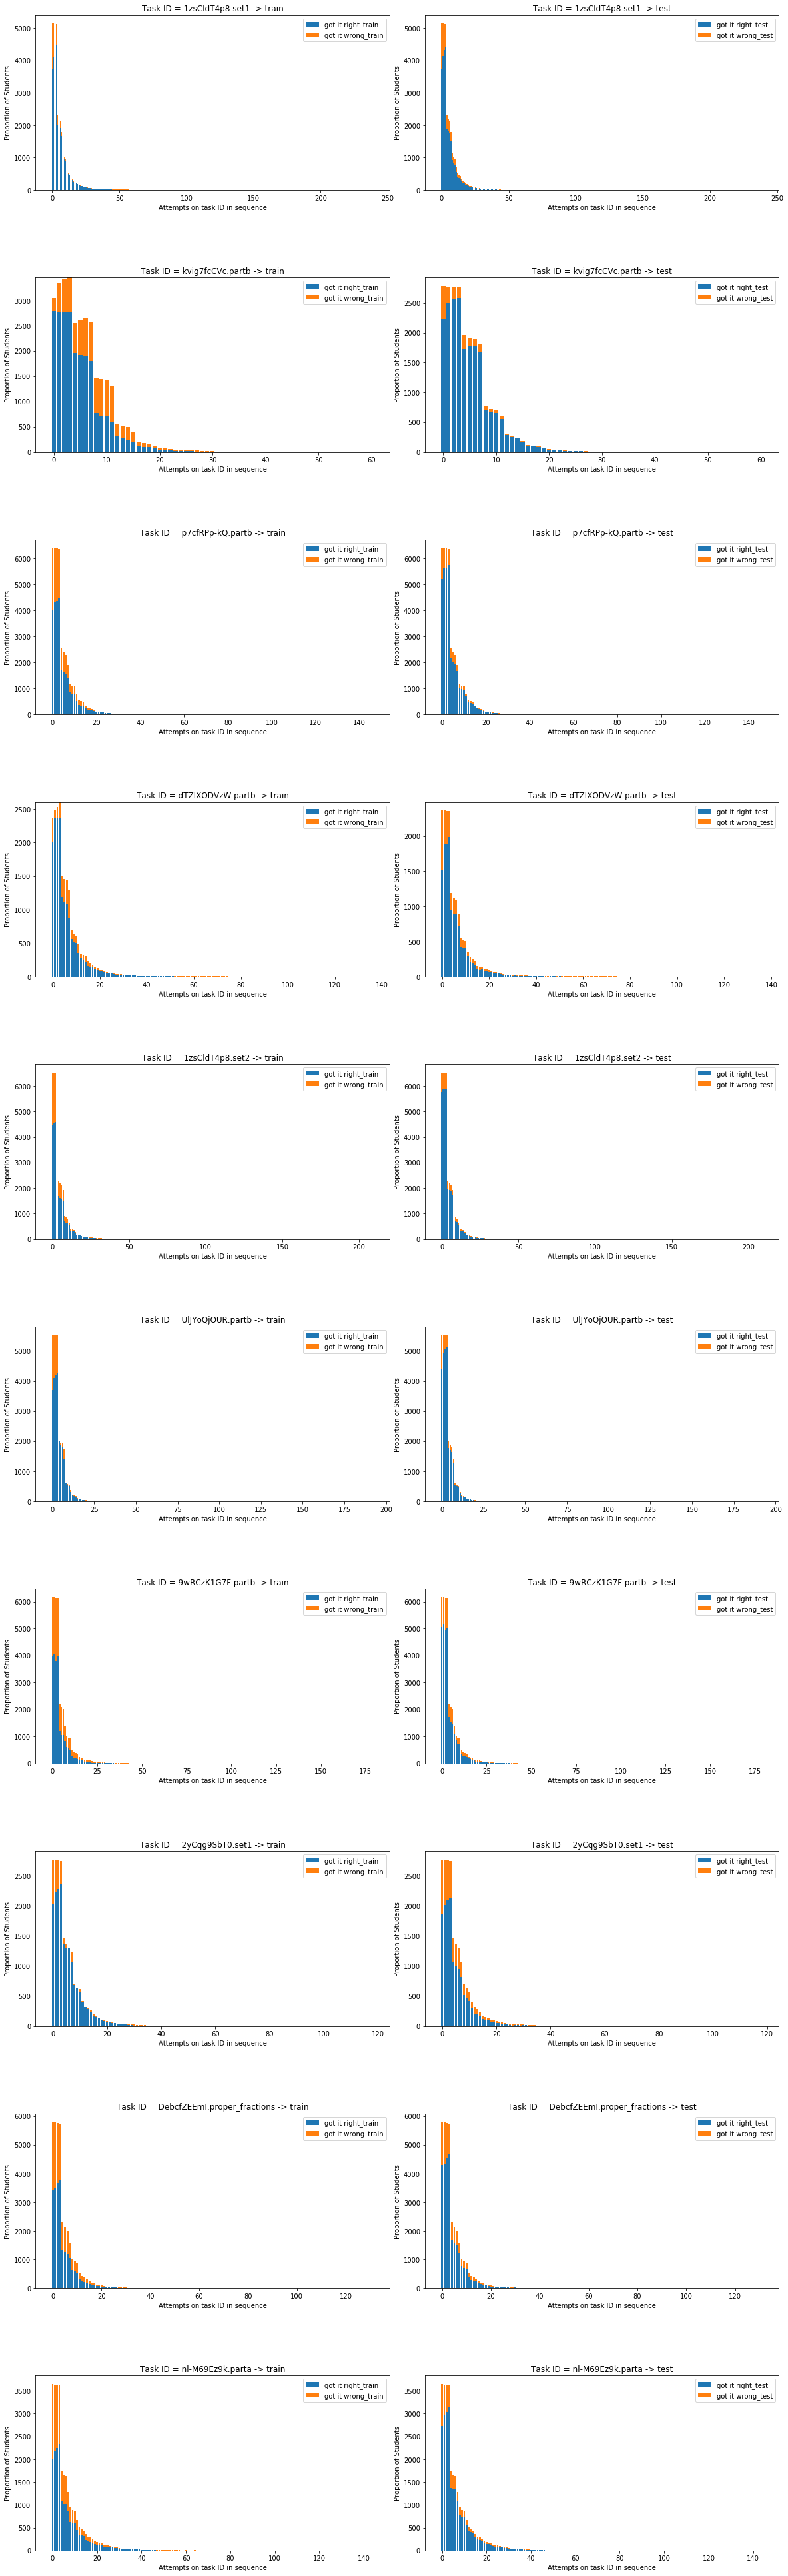

In [18]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if(k=='train'):
            axs[2*i].bar(ind,proportion_right_train[value],label="got it right_train")
            axs[2*i].bar(ind,proportion_wrong_train[value],bottom = proportion_right_train[value],label="got it wrong_train")
            #axs[2*i].set_ylim(0,1.31)
            axs[2*i].legend(loc="best") 
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Proportion of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + str(k))
        else:
            axs[2*i+1].bar(ind,proportion_right_test[value],label="got it right_test")
            axs[2*i+1].bar(ind,proportion_wrong_test[value],bottom = proportion_right_test[value],label="got it wrong_test")
            #axs[2*i+1].set_ylim(0,1.31)
            axs[2*i+1].legend(loc="best") 
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Proportion of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + str(k))
plt.savefig('right_wrong_10x.png')

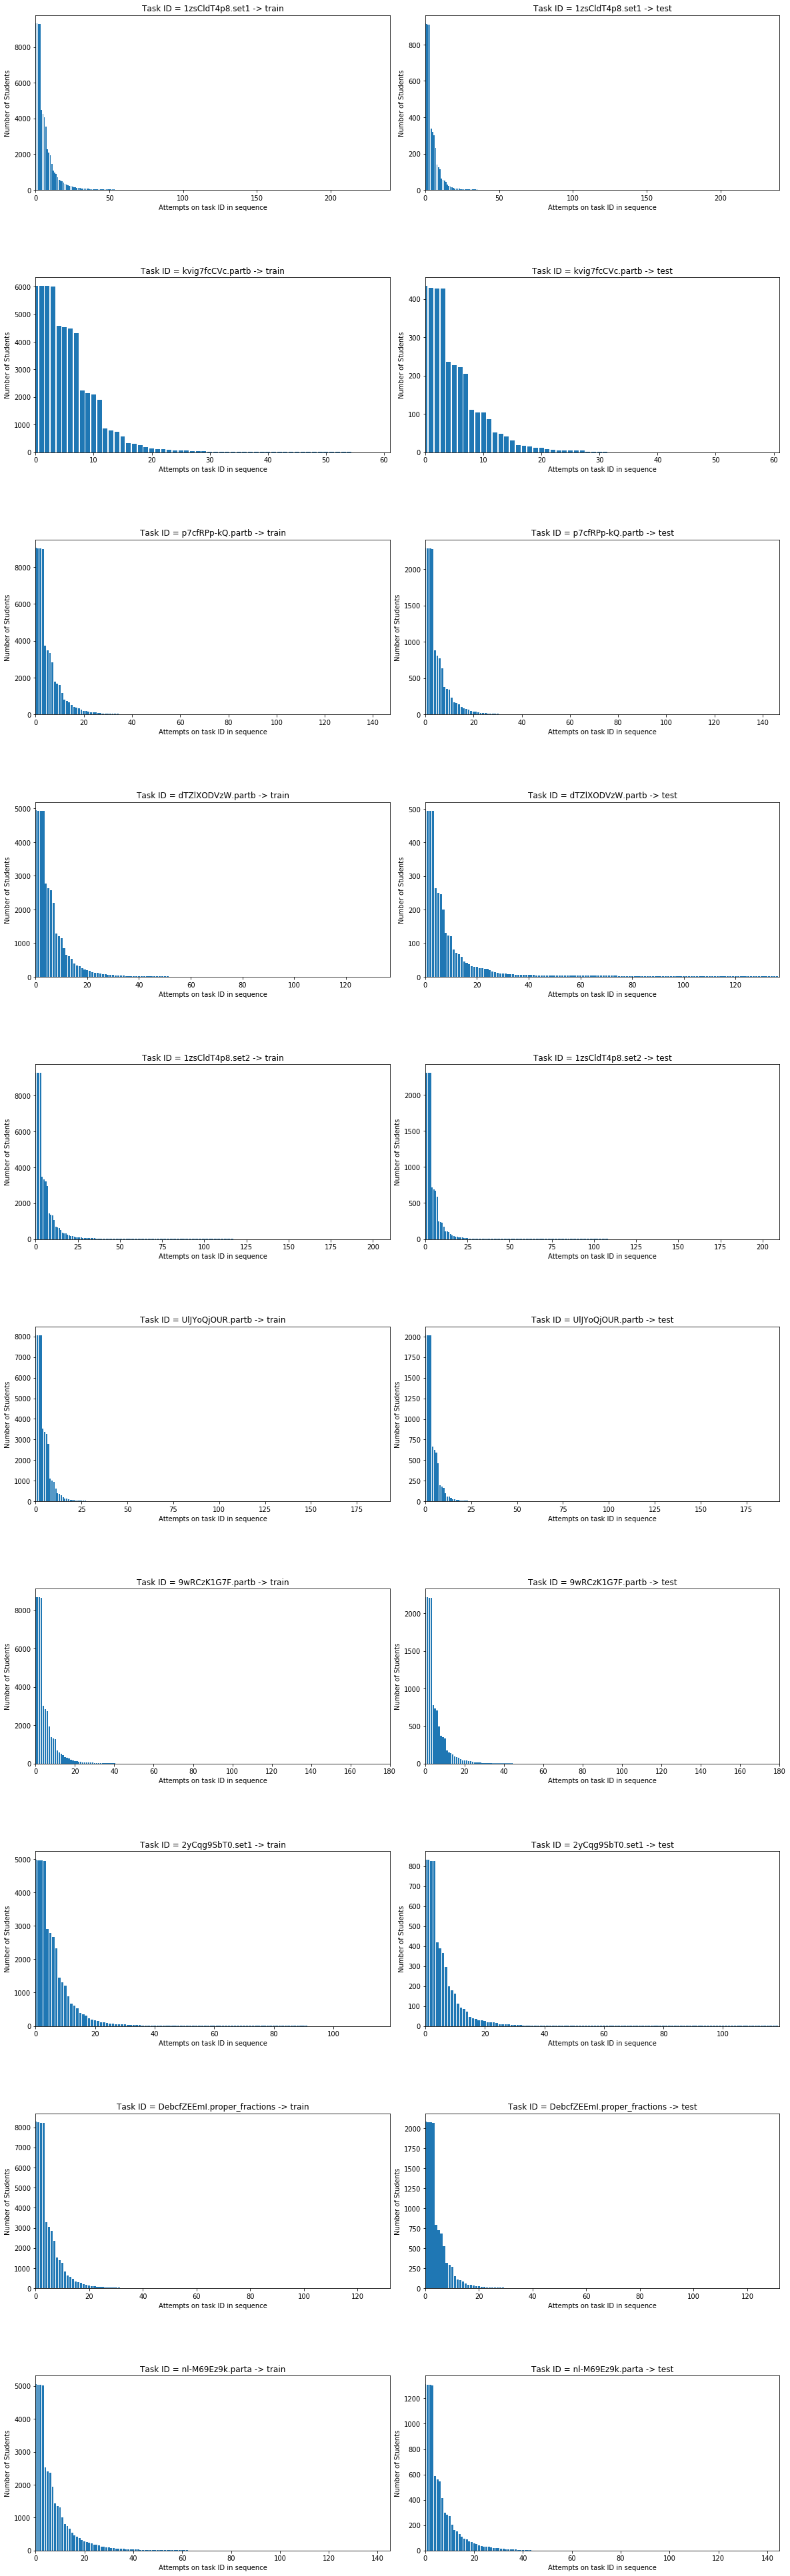

In [108]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if k=='train':
            axs[2*i].bar(ind,num_of_students_train[value])
            #axs[2*i].set_ylim(0,2000)
            axs[2*i].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Number of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + k)
        else:
            axs[2*i+1].bar(ind,num_of_students_test[value])
            #axs[2*i+1].set_ylim(0,1300)
            axs[2*i+1].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Number of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + k)
plt.savefig('num_students.png')